# Neural Network (ANN)

Five different supervised learning classification models are assessed to understand how well they could predict energy efficiency. Linear regression is selected as the baseline and the variance score (R2) as the quality measure used to assess the models. The other four algorithms are random forest, ada boost, XGBoost and a neural network.

This script prepares the data for modelling and can be used to the neural network.

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.metrics import mean_squared_error, r2_score
import random
from numpy.random import seed

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# set variables from config file
config_path = os.path.abspath('..')[:-7]

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
epc_train_ex_fname = config['DEFAULT']['epc_train_ex_fname']
epc_test_ex_fname = config['DEFAULT']['epc_test_ex_fname']
epc_train_do_fname = config['DEFAULT']['epc_train_domain_fname']
epc_test_do_fname = config['DEFAULT']['epc_test_domain_fname']
epc_train_dd_fname = config['DEFAULT']['epc_train_dd_fname']
epc_test_dd_fname = config['DEFAULT']['epc_test_dd_fname']
urban_rural_fname = config['DEFAULT']['urban_rural_fname']

In [3]:
epc_train_ex = pd.read_csv(os.path.join(processing_path,epc_train_ex_fname),header = 0,delimiter = ',')
epc_test_ex = pd.read_csv(os.path.join(processing_path,epc_test_ex_fname),header = 0,delimiter = ',')
epc_train_do = pd.read_csv(os.path.join(processing_path,epc_train_do_fname),header = 0,delimiter = ',')
epc_test_do = pd.read_csv(os.path.join(processing_path,epc_test_do_fname),header = 0,delimiter = ',')
epc_train_dd = pd.read_csv(os.path.join(processing_path,epc_train_dd_fname),header = 0,delimiter = ',')
epc_test_dd = pd.read_csv(os.path.join(processing_path,epc_test_dd_fname),header = 0,delimiter = ',')

Text(0.5, 0, 'epc_test_data_driven')

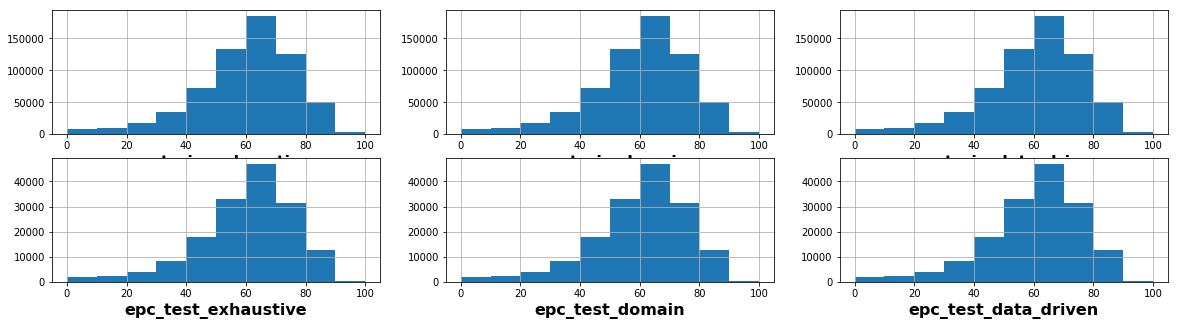

In [4]:
# plot distribution for each feature set
plt.figure(figsize=(20,5))

plt.subplot(231)
epc_train_ex['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_train_exhaustive',fontsize=16, weight='bold')

plt.subplot(232)
epc_train_do['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_train_domain',fontsize=16, weight='bold')

plt.subplot(233)
epc_train_do['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_train_data_driven',fontsize=16, weight='bold')

plt.subplot(234)
epc_test_ex['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_test_exhaustive',fontsize=16, weight='bold')

plt.subplot(235)
epc_test_do['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_test_domain',fontsize=16, weight='bold')

plt.subplot(236)
epc_test_do['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_test_data_driven',fontsize=16, weight='bold')

### process data for selected feature set

In [7]:
def process_data_for_modelling(training_data,test_data):
    
    ''' 
    Prepares the data for modelling by one hot encoding the categorical features, converting discrete values into
    strings and dropping BUILDING_REFERENCE_NUMBER
    Parameters
      training_data: a dataframe of training data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
      test_data: a dataframe of test data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
    Returns two dataframes 
    '''
    
    training_data['mode'] = 'train'
    test_data['mode'] = 'test'
    epc = pd.concat([training_data, test_data])
    epc = epc.reset_index(drop = True)
    
    try:
        epc.drop(['LODGEMENT_DATE'],axis=1,inplace=True)
    except:
        pass
    
    try:
    epc['EXTENSION_COUNT'] = epc['EXTENSION_COUNT'].astype('str')
    epc['NUMBER_OPEN_FIREPLACES'] = epc['NUMBER_OPEN_FIREPLACES'].astype('str')
    except:
        pass
    
    for col in epc.dtypes[epc.dtypes == 'object'].index:
        if col not in ['mode']:
            print(col)
            for_dummy = epc.pop(col)
            epc = pd.concat([epc, pd.get_dummies(for_dummy, prefix=col)], axis=1)
        
    features_to_drop = ['BUILDING_REFERENCE_NUMBER']
    epc.drop(features_to_drop,axis=1,inplace=True)
    
    #Split back into train and test
    training_data = epc[epc['mode']=='train']
    test_data = epc[epc['mode']=='test']
    test_data = test_data.reset_index(drop=True)
    inputs_train = training_data.drop('mode',axis=1)
    inputs_test = test_data.drop('mode',axis=1)
    
    return inputs_train, inputs_test

In [9]:
inputs_train, inputs_test = process_data_for_modelling(epc_train_ex, epc_test_ex)

region
PROPERTY_TYPE
BUILT_FORM
TRANSACTION_TYPE
ENERGY_TARIFF
MAINS_GAS_FLAG
FLOOR_LEVEL
MAIN_HEATING_CONTROLS
GLAZED_TYPE
EXTENSION_COUNT
NUMBER_OPEN_FIREPLACES
HOTWATER_DESCRIPTION
FLOOR_DESCRIPTION
WINDOWS_DESCRIPTION
WALLS_DESCRIPTION
ROOF_DESCRIPTION
HEAT_LOSS_CORRIDOOR
LIGHTING_DESCRIPTION


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [11]:
def scale_numeric(df,col):
    
    null_index = df[col].isnull()
    df.loc[~null_index, [col]] = scaler.fit_transform(df.loc[~null_index, [col]])
    
    return df

In [12]:
inputs_train = scale_numeric(inputs_train,'TOTAL_FLOOR_AREA')
inputs_test = scale_numeric(inputs_test,'TOTAL_FLOOR_AREA')
try:
    inputs_train = scale_numeric(inputs_train,'FLOOR_HEIGHT')
    inputs_test = scale_numeric(inputs_test,'FLOOR_HEIGHT')
except:
    pass
try:
    inputs_train = scale_numeric(inputs_train,'NUMBER_HABITABLE_ROOMS')
    inputs_test = scale_numeric(inputs_test,'NUMBER_HABITABLE_ROOMS')
except:
    pass

### check and fill missing values

In [13]:
numeric_cols = inputs_train.dtypes[inputs_train.dtypes == 'float'].index

In [14]:
inputs_train[numeric_cols].isnull().sum().sort_values(ascending = False) / inputs_train.shape[0]

FLOOR_HEIGHT                 0.459413
NUMBER_HABITABLE_ROOMS       0.086999
TOTAL_FLOOR_AREA             0.000000
CURRENT_ENERGY_EFFICIENCY    0.000000
dtype: float64

In [15]:
try:
    inputs_train['FLOOR_HEIGHT'] = inputs_train['FLOOR_HEIGHT'].fillna(inputs_train['FLOOR_HEIGHT'].mean())
    inputs_test['FLOOR_HEIGHT'] = inputs_test['FLOOR_HEIGHT'].fillna(inputs_test['FLOOR_HEIGHT'].mean())
    inputs_train['NUMBER_HABITABLE_ROOMS'] = inputs_train['NUMBER_HABITABLE_ROOMS'].fillna(inputs_train['NUMBER_HABITABLE_ROOMS'].mean())
    inputs_test['NUMBER_HABITABLE_ROOMS'] = inputs_test['NUMBER_HABITABLE_ROOMS'].fillna(inputs_test['NUMBER_HABITABLE_ROOMS'].mean())
except:
    pass

### create final dataframes

In [16]:
target_train = inputs_train['CURRENT_ENERGY_EFFICIENCY']
inputs_train = inputs_train.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)
target_test = inputs_test['CURRENT_ENERGY_EFFICIENCY']
inputs_test = inputs_test.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)

### train the model

In [17]:
seed(5)

#Instantiate network and early stopping monitor (stop training if
#validation error doesnt drop for 2 successive epochs)
deep_model = Sequential()
deep_model_monitor = EarlyStopping(patience = 2)

#Specify architecture
n_inputs = inputs_train.shape[1]

deep_model.add(Dense(120,activation = 'relu', input_shape = (n_inputs,)))
deep_model.add(Dense(60,activation = 'relu'))
deep_model.add(Dense(10,activation = 'relu'))
deep_model.add(Dense(4,activation = 'relu'))
deep_model.add(Dense(1,activation = 'relu'))

#Get the total number of tunable parameters)
print("Total network parameters:  %i" % deep_model.count_params())

deep_model.compile(optimizer = 'adam',loss = 'mean_squared_error')

#Train the model
deep_model.fit(inputs_train,target_train, epochs = 999,
               validation_split = 0.1, callbacks = [deep_model_monitor])




Total network parameters:  132839



Train on 569346 samples, validate on 63261 samples
Epoch 1/999
569346/569346 [==============================] - 63s 111us/step - loss: 61.4912 - val_loss: 49.7645
Epoch 2/999
569346/569346 [==============================] - 61s 106us/step - loss: 47.7440 - val_loss: 47.6705
Epoch 3/999
569346/569346 [==============================] - 61s 106us/step - loss: 46.6245 - val_loss: 47.1223
Epoch 4/999
569346/569346 [==============================] - 61s 106us/step - loss: 45.8915 - val_loss: 46.1510
Epoch 5/999
569346/569346 [==============================] - 61s 106us/step - loss: 45.3060 - val_loss: 45.9601
Epoch 6/999
569346/569346 [==============================] - 62s 109us/step - loss: 44.8552 - val_loss: 47.6196
Epoch 7/999
569346/569346 [==============================] - 60s 106us/step - loss: 44.4522 - val_loss: 46.0994


In [18]:
#Get performance on training and test data
predict_train = deep_model.predict(inputs_train)
predict_test = deep_model.predict(inputs_test)
train_r_squared = r2_score(target_train,predict_train)
test_r_squared = r2_score(target_test,predict_test)
train_mse = mean_squared_error(target_train,predict_train)
test_mse = mean_squared_error(target_test,predict_test)
r2_delta = abs(train_r_squared - test_r_squared)
print('\tVariance scores:\t%.4f\t%.4f' % (train_r_squared,test_r_squared))
print('\tMean squared error:\t%.4f\t%.4f' % (train_mse, test_mse))
print("\tR2 delta\t\t%f" % r2_delta)

	Variance scores:	0.8277	0.8190
	Mean squared error:	43.8087	45.5159
	R2 delta		0.008709


## Results by band

In [22]:
# predict_test_series = pd.Series(predict_test)
test_scored = pd.DataFrame(target_test)
test_scored = test_scored.reset_index(drop=True)
test_scored['predicted_score'] = predict_test

In [24]:
band_bins = [-1,0,20,38,54,68,80,91,100]
band_labels = ['I','G','F','E','D','C','B','A']
test_scored['predicted_band'] = pd.cut(test_scored['predicted_score'],bins = band_bins, labels = band_labels)
test_scored['actual_band'] = pd.cut(test_scored['CURRENT_ENERGY_EFFICIENCY'],bins = band_bins, labels = band_labels)

In [25]:
# average accuracy per band
(test_scored['actual_band'] == test_scored['predicted_band']).sum()/len(test_scored)

0.6858338813293541

In [26]:
# accuracy for each band
test_scored['correct_band'] = test_scored['actual_band'] == test_scored['predicted_band']
test_scored.groupby('actual_band')['correct_band'].sum()/test_scored.groupby('actual_band')['correct_band'].count()

actual_band
I    0.000000
G    0.475523
F    0.474977
E    0.659698
D    0.756316
C    0.696329
B    0.632007
A    0.131274
Name: correct_band, dtype: float64

In [27]:
# manipulating data for heatmap
for_heatmap = test_scored[['actual_band','predicted_band']]
for_dummy = for_heatmap.pop('actual_band')
for_heatmap = pd.concat([for_heatmap, pd.get_dummies(for_dummy)], axis=1)
for_heatmap_summed = for_heatmap.groupby('predicted_band')['A','B','C','D','E','F','G'].sum()

In [28]:
def get_pct(x):
    return (x/(x.sum()))*100

In [29]:
for_heatmap_summed = for_heatmap_summed.apply(get_pct,axis = 0)

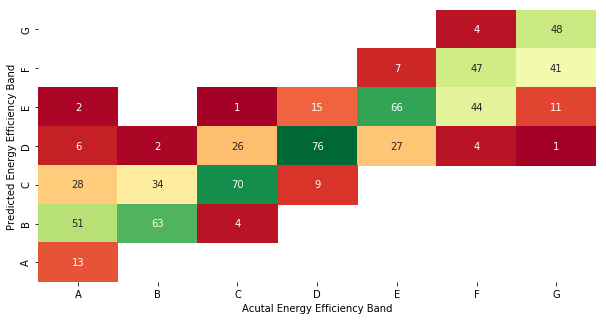

In [30]:
heatmap_test = round(for_heatmap_summed,0)
heatmap_test = heatmap_test.replace(0,np.nan)
heatmap_test = heatmap_test.loc[['G','F','E','D','C','B','A'],:]

f = plt.figure(figsize=(10,5))
sns.heatmap(heatmap_test, cmap='RdYlGn',annot=True,cbar=False)
plt.xlabel('Acutal Energy Efficiency Band')
plt.ylabel('Predicted Energy Efficiency Band')
plt.show()